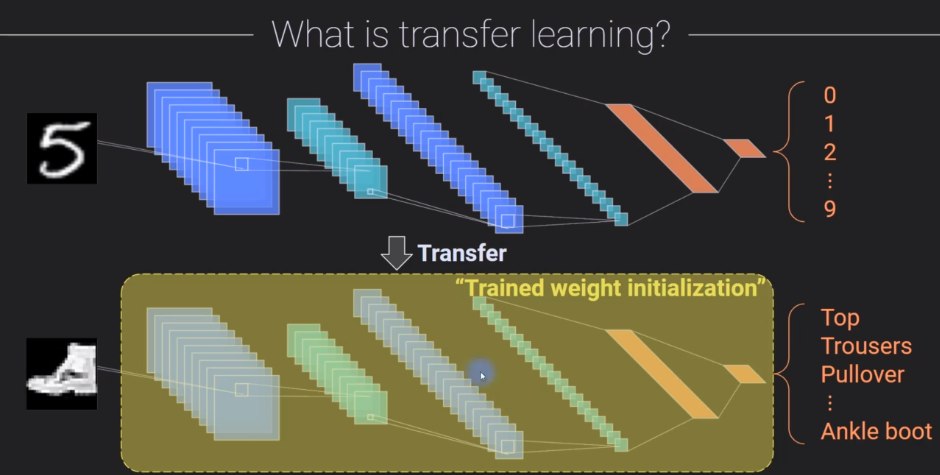

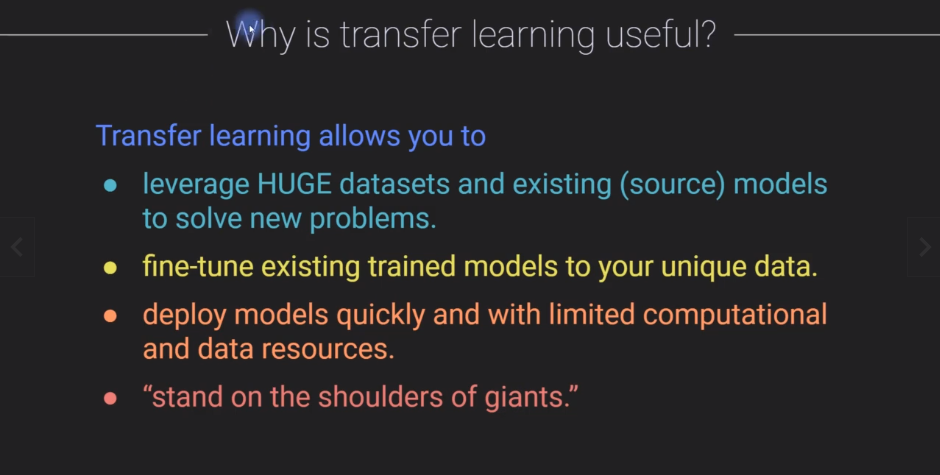

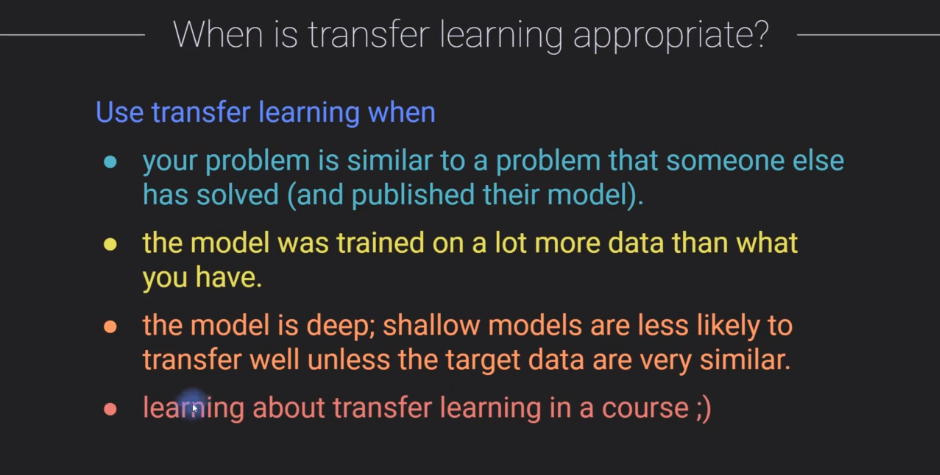

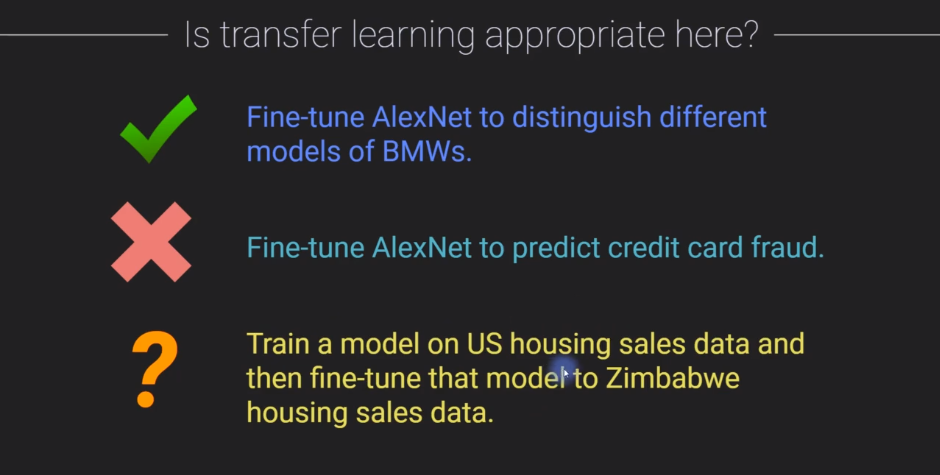

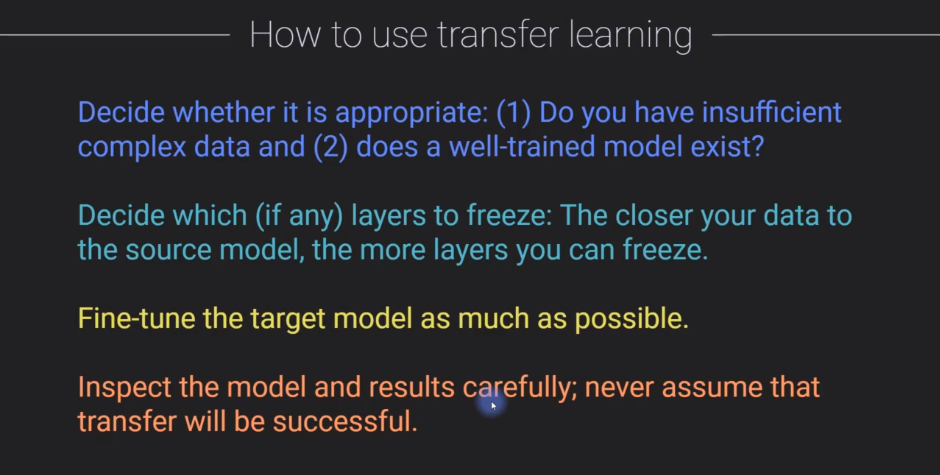

# Transfer Learning from MNIST -> FMNIST

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import copy
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

### Importing and processing data

In [3]:
data = np.loadtxt(open('../data/mnist_train_small.csv'), delimiter=',')

labelsT = torch.tensor(data[:, 0]).long()
data = data[:, 1:]
dataNorm = data/np.max(data)
dataNormT = torch.tensor(dataNorm.reshape(dataNorm.shape[0],1,28,28)).float()

X_train, X_test, y_train, y_test = train_test_split(dataNormT, labelsT, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [11]:
# Importing FMNIST dataset

transform = T.Compose([T.ToTensor(), T.Normalize(.5, .5)])

trainset = torchvision.datasets.FashionMNIST(root="../data/", train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root="../data/", train=False, download=True, transform=transform)

batchsize = 32
FtrainLoader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
FtestLoader = DataLoader(testset, batch_size=len(testset))

In [6]:
def createMNISTnet(printtoggle=False):
    class MNISTNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()
            
            # conv layers
            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
            # size = np.floor((28+2*1-5)/1)+1 = 26/2 = 13 (/2 for maxpool) - op of this layer is 26x26, op of maxpool is 13x13
            
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            # size = np.floor((13+2*1-5)/1)+1 = 11/2 = 5 (/2 for maxpool) - op of this layer is 11x11, op of maxpool is 5x5
            
            # computing no of units in FC layer (op of conv2)
            expectSize = np.floor((5+2*0-1)/1) + 1 # fc1 layer has no padding or kernel, so set to 0/1
            expectSize = 20*int(expectSize**2)
            
            # fully connected layer
            self.fc1 = nn.Linear(expectSize, 50)
            
            self.op = nn.Linear(50, 10) # op layer
            
            # toggle for printing tensors during forward prop
            self.print = printtoggle
            
        def forward(self, x):
            print(f'Input: {x.shape}') if self.print else None
            
            # convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            print(f'Layer conv1/pool1: {x.shape}') if self.print else None
            
            # and again: convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None
            
            # reshaping for linear layer
            nUnits = x.shape.numel()/x.shape[0] # nUnits is 500 at this point - 20x5x5
            x = x.view(-1, int(nUnits))
            
#             print('printing x.shape.numel():', x.shape.numel())
#             print('printing x.shape[0]:', x.shape[0])
#             print('printing x.view(-1, int(nUnits)):', x.view(-1, int(nUnits)))
            
            if self.print: print(f'Vectorize: {x.shape}')
            
            # linear layers
            x = F.relu(self.fc1(x))
            if self.print: print(f'Layer fc1: {x.shape}')
            x = self.op(x)
            if self.print: print(f'Layer out: {x.shape}')
            
            return x
        
    net = MNISTNet(printtoggle)

    lossfn = nn.CrossEntropyLoss()

    optim = torch.optim.Adam(net.parameters(), lr=0.001)
        
    return net, lossfn, optim

In [30]:
# function to train model

# a function that trains the model

def trainModel(net, trainLoader, testLoader, numepochs=10):


    # initialize losses
    losses    = torch.zeros(numepochs)
    trainAcc  = []
    testAcc   = []


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in trainLoader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
            batchAcc.append( accuracyPct )               # add to list of accuracies
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y = next(iter(testLoader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

        # end epochs

    # function output
    return net, losses, trainAcc, testAcc


In [42]:
# create a new model
net,lossfun,optimizer = createMNISTnet()
net, losses, trainAcc, testAcc = trainModel(net, trainLoader, testLoader, 5)

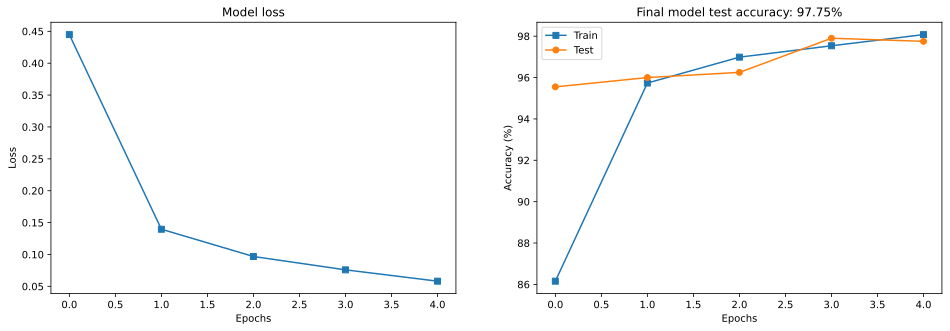

In [43]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Testing the Model on Fashion data

In [44]:
X, y = next(iter(FtestLoader))
yH = net(X)

# accuracy
f_acc = 100*torch.mean((torch.argmax(yH,axis=1)==y).float())

print(f'Accuracy on Fashion data: {f_acc:.2f}%')

Accuracy on Fashion data: 12.81%


## Fine-tuning the model with one epoch

In [45]:
f_net, lossfn, optimizer = createMNISTnet() # create MNist net

# replace all of weights in target model (f_net) from our source model (original mnist net)
for tgt, src in zip(f_net.named_parameters(), net.named_parameters()):
    tgt[1].data = copy.deepcopy(src[1].data)

In [46]:
# retrain the model with new net
f_net, losses, trainAcc, testAcc = trainModel(f_net, FtrainLoader, FtestLoader, 1)

In [47]:
print('Train Accuracy :', trainAcc[-1])
print('Test Accuracy:', testAcc[-1])

Train Accuracy : 82.18667
Test Accuracy: tensor(86.2100)


### Comparing results by training FMNIST from scratch

In [48]:
f_net, lossfn, optimizer = createMNISTnet() # create FMNIST net

f_net, losses, trainAcc, testAcc = trainModel(f_net, FtrainLoader, FtestLoader, 1)

print('Train Accuracy :', trainAcc[-1])
print('Test Accuracy:', testAcc[-1])

Train Accuracy : 81.31
Test Accuracy: tensor(86.6100)


# Famous CNN Architectures

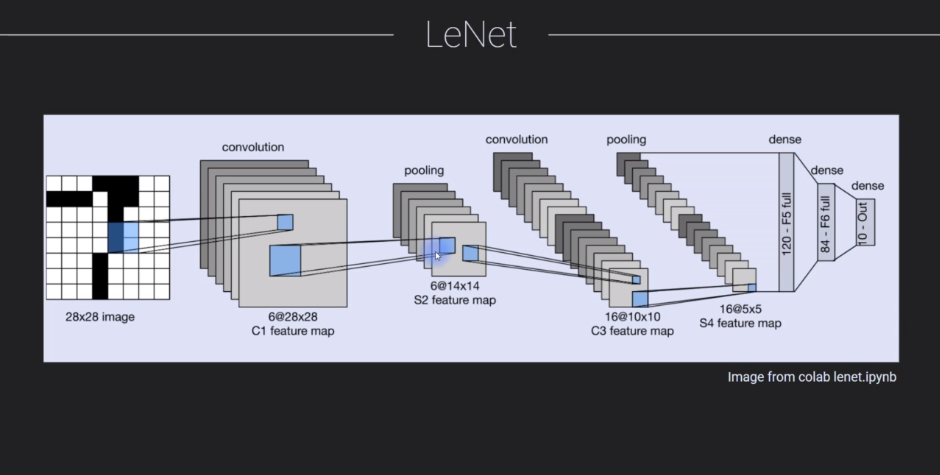

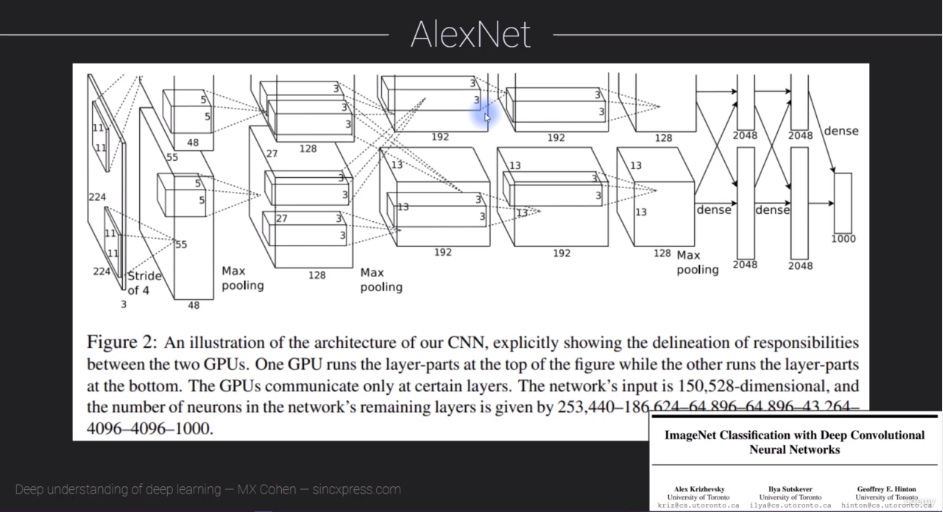

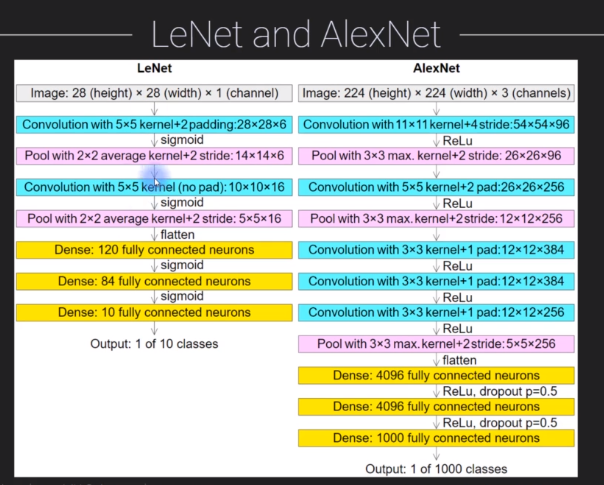

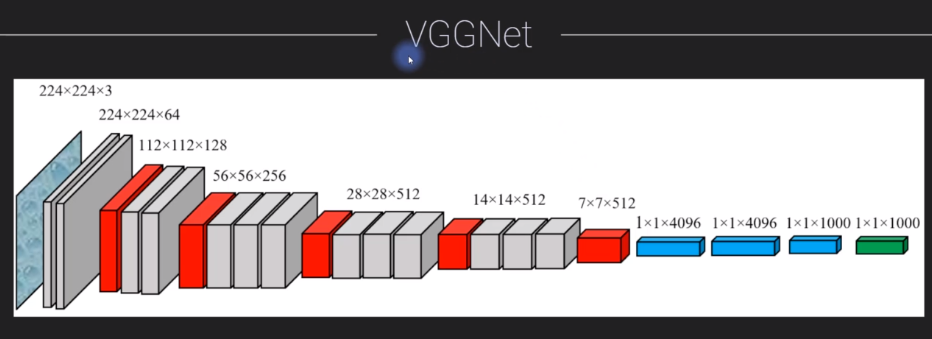

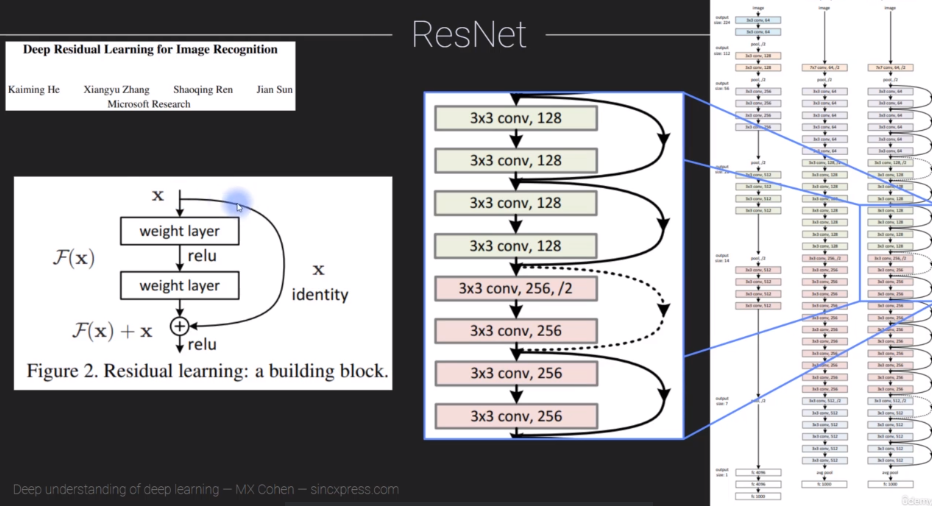

# Transfer Learning with ResNet-18

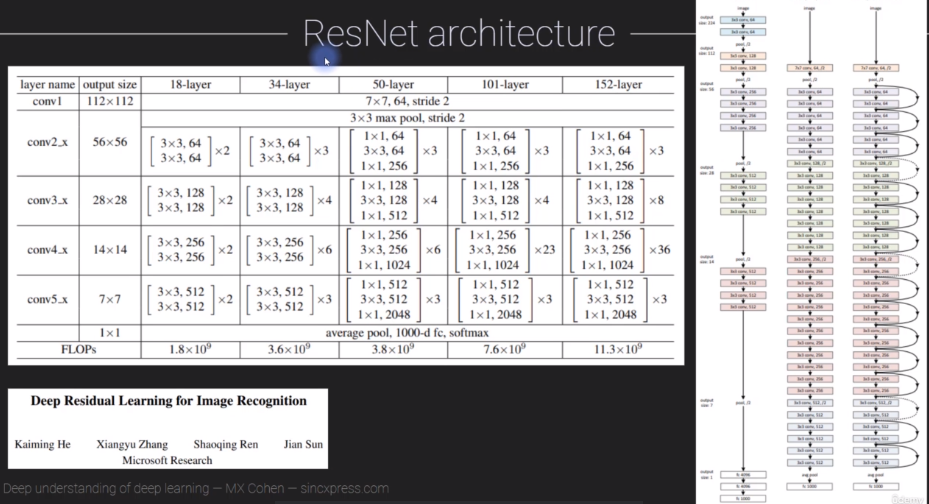

Downloading pre-trained model ResNet-18.  
Freezing model and replacing and retraining only output layer  
Testing Categorization performance of ResNet on STL10 dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import copy
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [83]:
# transformations
transform = T.Compose([
    T.ToTensor(), # normalizes to range (0,1)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.STL10(root='../data/', download=True, split='train',transform=transform)
testset = torchvision.datasets.STL10(root='../data/', download=True, split='test',transform=transform)

batchsize = 32
trainLoader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(testset, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


In [85]:
trainset.data.shape, testset.data.shape

((5000, 3, 96, 96), (8000, 3, 96, 96))

In [86]:
np.min(trainset.data), np.max(trainset.data)

(0, 255)

In [87]:
trainset.classes

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

In [88]:
X, y = next(iter(trainLoader))
X.data.shape

torch.Size([32, 3, 96, 96])

In [89]:
torch.min(X.data), torch.max(X.data) # unnormalized

(tensor(-2.1179), tensor(2.6400))

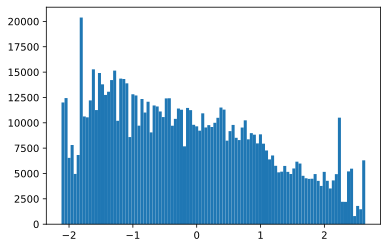

In [92]:
plt.hist(X.data.numpy().flatten(), 100)
plt.show()

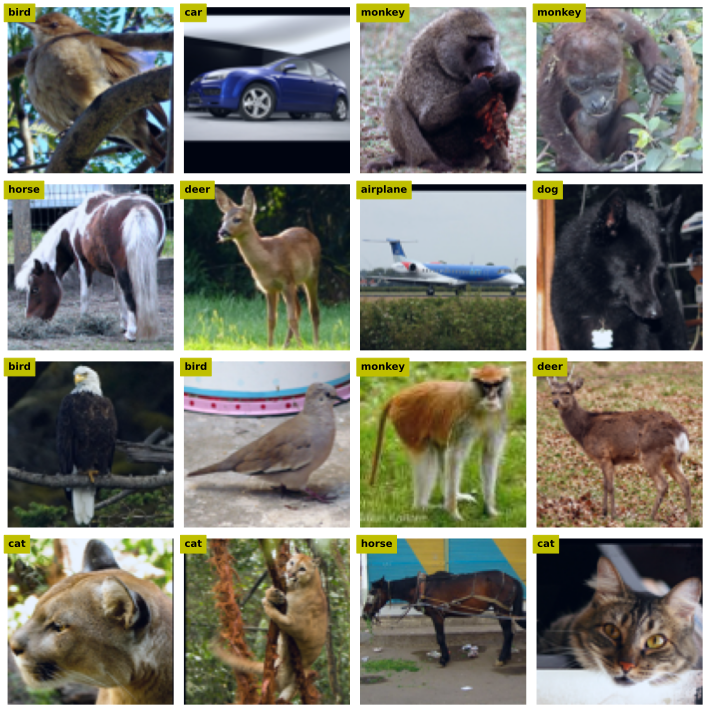

In [93]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic-np.min(pic) # undo normalization
    pic = pic/np.max(pic)

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Importing and inspecting ResNet model

In [94]:
resnet = torchvision.models.resnet18(pretrained=True) # gets pre-trained model

# if False, gives resnet architecture from scratch

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/yash/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:17<00:00, 2.69MB/s]


In [95]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [97]:
from torchsummary import summary

summary(resnet.to(device), (3,96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [98]:
# freezing all layers 
for i in resnet.parameters():
    i.requires_grad = False

In [99]:
# Changing final layer
resnet.fc = nn.Linear(512, 10)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [109]:
# training the model

lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(),lr=0.001)

numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over training data batches
    resnet.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in trainLoader:

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        yHat = resnet(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance (here done in batches!)
    resnet.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    for X,y in testLoader:

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        with torch.no_grad():
            yHat = resnet(X)
            loss = lossfun(yHat,y)

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)
    testAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')


Finished epoch 1/10. Test accuracy = 78.23%
Finished epoch 2/10. Test accuracy = 77.93%
Finished epoch 3/10. Test accuracy = 78.53%
Finished epoch 4/10. Test accuracy = 79.10%
Finished epoch 5/10. Test accuracy = 77.69%
Finished epoch 6/10. Test accuracy = 77.93%
Finished epoch 7/10. Test accuracy = 79.38%
Finished epoch 8/10. Test accuracy = 79.47%
Finished epoch 9/10. Test accuracy = 78.96%
Finished epoch 10/10. Test accuracy = 78.41%


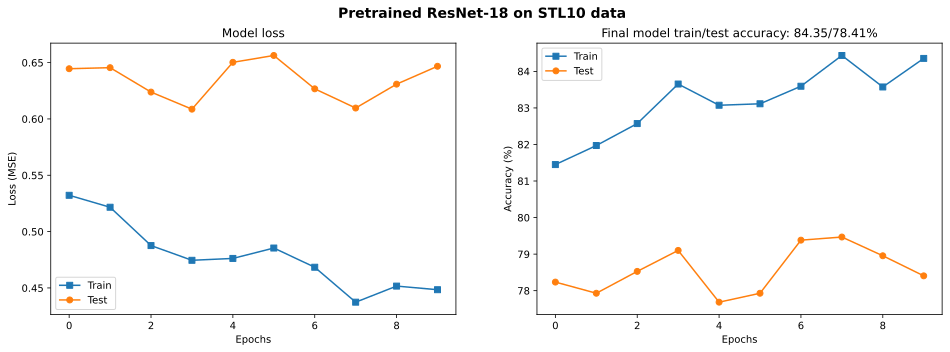

In [110]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

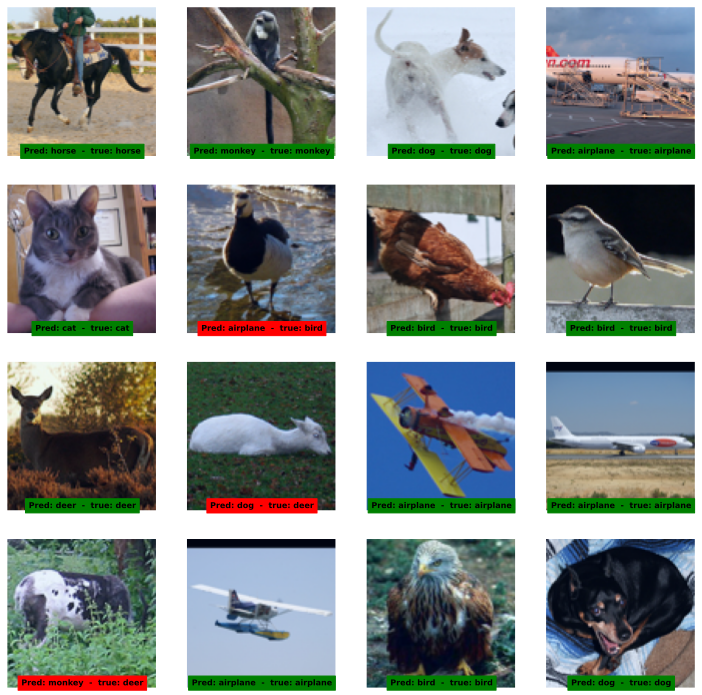

In [111]:
# inspect a few random images

X,y = next(iter(testLoader))
X = X.to(device)
y = y.to(device)
resnet.eval()
predictions = torch.argmax( resnet(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 96x96x3)
    pic = X.data[i].cpu().numpy().transpose((1,2,0))
    pic = pic-np.min(pic) # undo normalization
    pic = pic/np.max(pic)

    # show the image
    ax.imshow(pic)


    # label and true class
    label = trainset.classes[predictions[i]]
    truec = trainset.classes[y[i]]
    title = f'Pred: {label}  -  true: {truec}'

    # set the title with color-coded accuracy
    titlecolor = 'g' if truec==label else 'r'
    ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Pretraining with Autoencoders

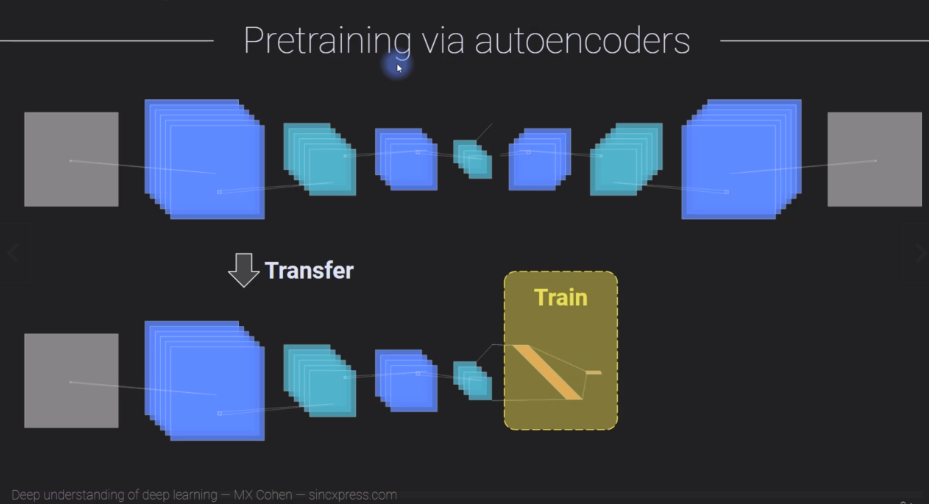

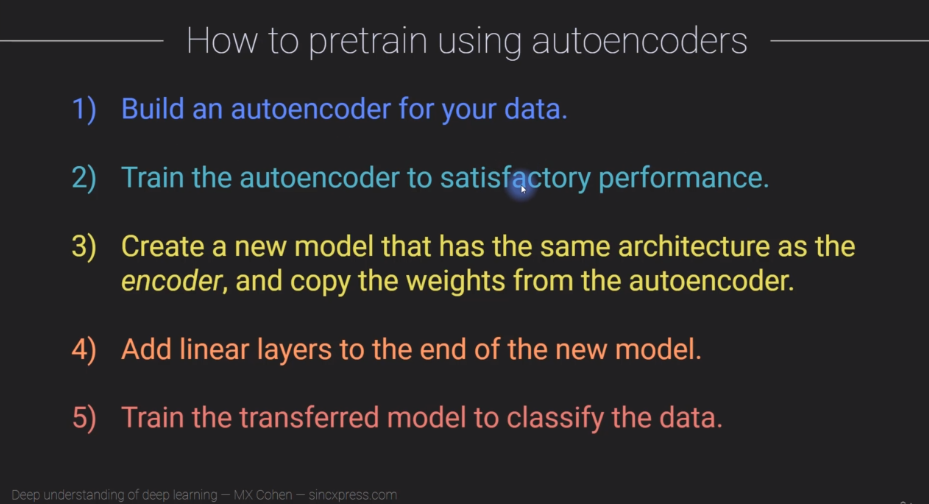

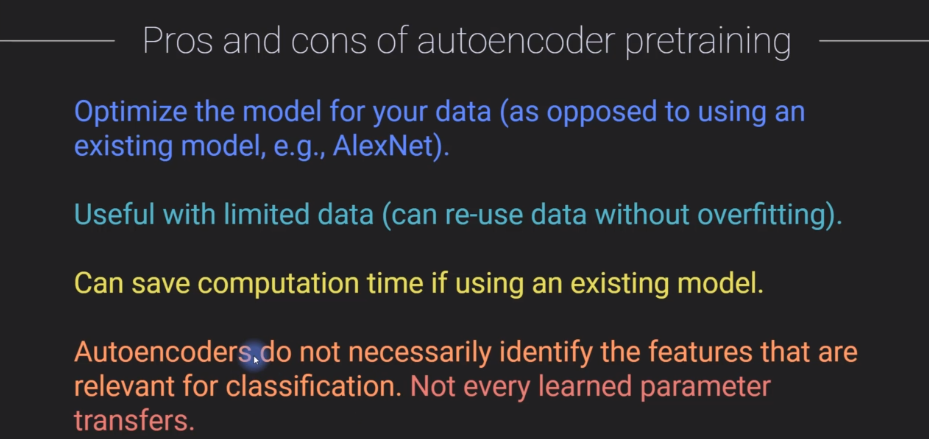

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import numpy as np
import copy
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Importing FMNIST dataset

transform = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(p=.5), T.Normalize(.5, .5)])

trainset = torchvision.datasets.FashionMNIST(root="../data/", train=True, download=True, transform=transform)
devtest = torchvision.datasets.FashionMNIST(root="../data/", train=False, download=True, transform=transform)

# splitting dev set into two sets
randidx = np.random.permutation(10000) # random permutation of indices
devset = Subset(devtest, randidx[:6000])
testset = Subset(devtest, randidx[6000:])


batchsize = 32
trainLoader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
devLoader = DataLoader(devset, batch_size=len(devset))
testLoader = DataLoader(testset, batch_size=len(testset))

In [12]:
# Creating AE model

def makeAENet():
    
    class AENet(nn.Module):
        def __init__(self):
            super().__init__()
            
            # encoder convolution layers
            self.Econv1 = nn.Conv2d(1,16,3,padding=1,stride=2)
            # op size = (28+2*1-3)/2 + 1 = 14
            
            self.Econv2 = nn.Conv2d(16,32,3,padding=1,stride=2)
            # op size = (14+2*1-3)/2 + 1 = 7
            
            # Decoder layers
            self.Dconv1 = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)
            
            self.Dconv2 = nn.ConvTranspose2d(16,1,4,padding=1,stride=2)
            
        def forward(self, x):
            x = F.leaky_relu(self.Econv1(x))
            x = F.leaky_relu(self.Econv2(x))
            x = F.leaky_relu(self.Dconv1(x))
            x = F.leaky_relu(self.Dconv2(x))
            
            return x
        
    net = AENet()
    lossfn = nn.MSELoss()
    optim = torch.optim.Adam(net.parameters(),lr=.001)

    return net, lossfn, optim

In [13]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeAENet()

X,y = next(iter(trainLoader))
yHat = tmpnet(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 1, 28, 28])
 
Loss:
tensor(0.7318, grad_fn=<MseLossBackward0>)


In [21]:
# a function that trains the model

def trainModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net,lossfun,optimizer = makeAENet()

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss   = torch.zeros(numepochs)


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train() # switch to train mode
        batchLoss = []
        for X,y in trainLoader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,X)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy from this batch
            batchLoss.append(loss.item())
        # end of batch loop...

        # and get average losses and accuracies across the batches
        trainLoss[epochi] = np.mean(batchLoss)


        #### test performance
        net.eval() # switch to test mode
        X,y = next(iter(devLoader))

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        with torch.no_grad():
            yHat = net(X)
            loss = lossfun(yHat,X)

        # and get average losses and accuracies across the batches
        devLoss[epochi] = loss.item()

    # end epochs

    # function output
    return net, trainLoss, devLoss

In [17]:
aenet, trainLoss, devLoss = trainModel()

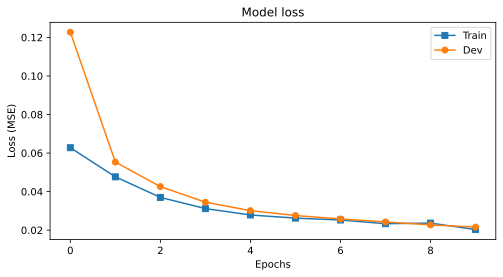

In [20]:
fig = plt.figure(figsize=(8,4))

plt.plot(trainLoss,'s-',label='Train')
plt.plot(devLoss,'o-',label='Dev')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')
plt.legend()

plt.show()

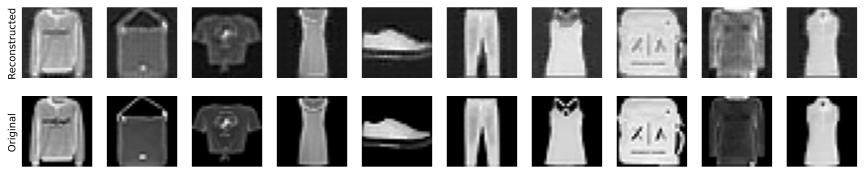

In [23]:
## show some random examples

# get some data
X,y = next(iter(devLoader))

# forward pass and loss
aenet.cpu()
aenet.eval() # switch to test mode
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,3))

for i in range(10):
    pic = yHat[i,0,:,:].detach()
    pic = pic/2 + .5 # undo normalization
    axs[0,i].imshow(pic,cmap='gray')
    axs[0,i].axis('off')

    pic = X[i,0,:,:].detach()
    pic = pic/2 + .5 # undo normalization
    axs[1,i].imshow(pic,cmap='gray')
    axs[1,i].axis('off')

    if i==0:
        axs[0,0].text(-6,14,'Reconstructed',rotation=90,va='center')
        axs[1,0].text(-6,14,'Original',rotation=90,va='center')

plt.show()

### Creating a new classifier model using the encoder part of architecture

In [25]:
def makeClassifier():
    
    class classNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            # Encoder layers (mimic encoder part of AE)
            self.Econv1 = nn.Conv2d(1,16,3,padding=1,stride=2)
            # op size = (28+2*1-3)/2 + 1 = 14
            
            self.Econv2 = nn.Conv2d(16,32,3,padding=1,stride=2)
            # op size = (14+2*1-3)/2 + 1 = 7
            
            # Linear layers
            
            self.fc1 = nn.Linear(7*7*32, 50)
            self.fc2 = nn.Linear(50, 10)
            
        def forward(self, x):
            x = F.leaky_relu(self.Econv1(x))
            x = F.leaky_relu(self.Econv2(x))
            
            nUnits = x.shape.numel()/x.shape[0] # reshaping to linear
            x = x.view(-1,int(nUnits))
            
            x = F.leaky_relu(self.fc1(x))
            return F.leaky_relu(self.fc2(x))
    
    net = classNet()
    lossfn = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(net.parameters(), lr=0.001)
    
    return net, lossfn, optim

In [27]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeClassifier()

X,y = next(iter(trainLoader))
yHat = tmpnet(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3060, grad_fn=<NllLossBackward0>)


### Function to train classifier

In [28]:
# a function that trains the model

def trainClassModel(net,lossfun,optimizer):

    # number of epochs
    numepochs = 10

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss   = torch.zeros(numepochs)
    trainAcc  = torch.zeros(numepochs)
    devAcc    = torch.zeros(numepochs)


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train() # switch to train mode
        batchLoss = []
        batchAcc  = []

        for X,y in trainLoader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy from this batch
            batchLoss.append(loss.item())
            batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        # end of batch loop...

        # and get average losses and accuracies across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi]  = 100*np.mean(batchAcc)


        #### test performance
        net.eval() # switch to test mode
        X,y = next(iter(devLoader))

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        with torch.no_grad():
            yHat = net(X)
            loss = lossfun(yHat,y)

        # and get average losses and accuracies across the batches
        devLoss[epochi] = loss.item()
        devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()
        # end epochs

    # function output
    return trainLoss,devLoss,trainAcc,devAcc,net

In [30]:
# train a new model from scratch (not pre-trained!)

# create a naive network
naivenet,lossfun,optimizer = makeClassifier()

# train it from scratch
trainLossNaive,devLossNaive,trainAccNaive,devAccNaive,naivenet = trainClassModel(naivenet,lossfun,optimizer)


## evaluate on the test set
naivenet.eval() # switch to test mode
X,y = next(iter(testLoader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
    yHat = naivenet(X)
    loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLossNaive = loss.item()
testAccNaive  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

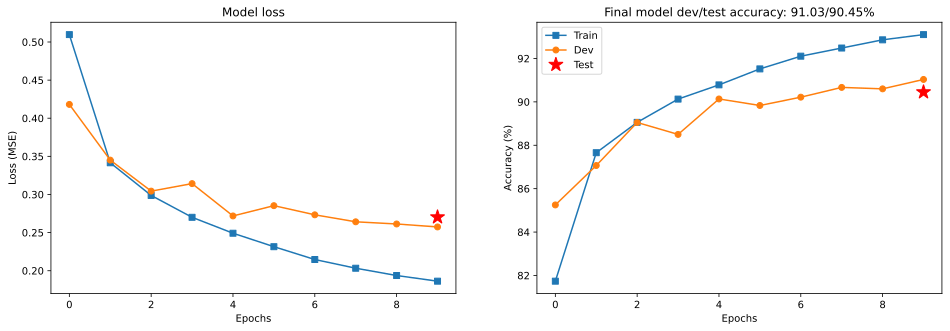

In [31]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossNaive,'s-',label='Train')
ax[0].plot(devLossNaive,'o-',label='Dev')
ax[0].plot(len(devLossNaive)-1,testLossNaive,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAccNaive,'s-',label='Train')
ax[1].plot(devAccNaive,'o-',label='Dev')
ax[1].plot(len(devAccNaive)-1,testAccNaive,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAccNaive[-1]:.2f}/{testAccNaive:.2f}%')
ax[1].legend()

plt.show()

## Building a model with transfer learning from AE

In [34]:
pretrainNet, lossfn, optim = makeClassifier()

# transferring weights of src model encoder part to new model
for tgt, src in zip(pretrainNet.named_parameters(), aenet.named_parameters()):
    if 'Econv' in tgt[0]:
        tgt[1].data = copy.deepcopy(src[1].data)

In [37]:
trainLossPre,devLossPre,trainAccPre,devAccPre,naivePre = trainClassModel(pretrainNet,lossfn,optim)

In [38]:
## evaluate on the test set
pretrainNet.eval() # switch to test mode
X,y = next(iter(testLoader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
    yHat = pretrainNet(X)
    loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLossPre = loss.item()
testAccPre  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

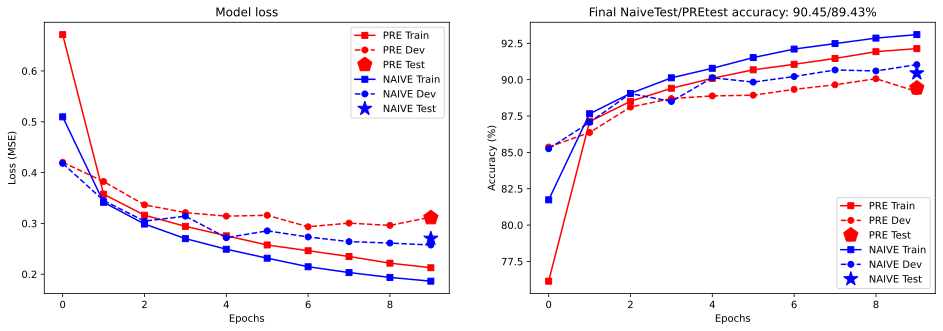

In [39]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossPre,'rs-',label='PRE Train')
ax[0].plot(devLossPre,'ro--',label='PRE Dev')
ax[0].plot(len(devLossPre)-1,testLossPre,'rp',markersize=15,label='PRE Test')
ax[0].plot(trainLossNaive,'bs-',label='NAIVE Train')
ax[0].plot(devLossNaive,'bo--',label='NAIVE Dev')
ax[0].plot(len(devLossNaive)-1,testLossNaive,'b*',markersize=15,label='NAIVE Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAccPre,'rs-',label='PRE Train')
ax[1].plot(devAccPre,'ro--',label='PRE Dev')
ax[1].plot(len(devAccPre)-1,testAccPre,'rp',markersize=15,label='PRE Test')
ax[1].plot(trainAccNaive,'bs-',label='NAIVE Train')
ax[1].plot(devAccNaive,'bo--',label='NAIVE Dev')
ax[1].plot(len(devAccNaive)-1,testAccNaive,'b*',markersize=15,label='NAIVE Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final NaiveTest/PREtest accuracy: {testAccNaive:.2f}/{testAccPre:.2f}%')
ax[1].legend()

plt.show()

### Checking if they differ by feature maps

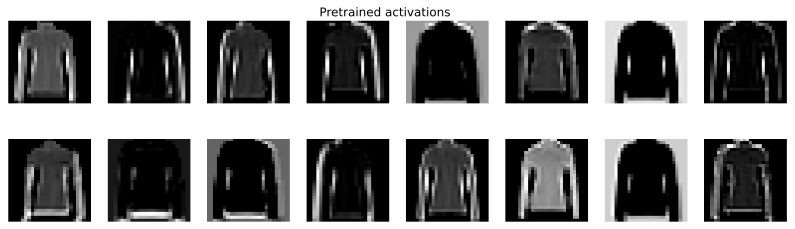

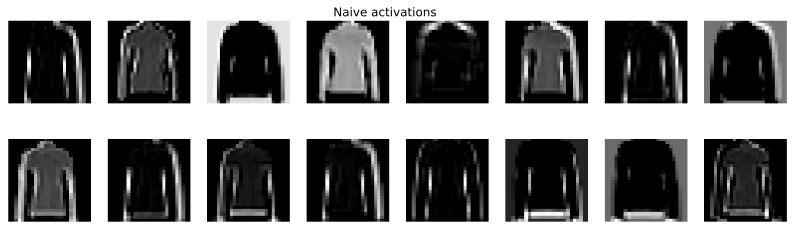

In [41]:
# grab one image
x = X[10,:,:,:].view(1,1,28,28)

# compute the activations of the first layer (excluding the bias b/c this is simply a constant)
layer1ActPre = F.relu( F.conv2d(x,pretrainNet.Econv1.weight) )
layer1ActNai = F.relu( F.conv2d(x,naivenet.Econv1.weight) )



## show the feature map activations for the pretrained model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
    act = torch.squeeze(layer1ActPre[0,i,:,:]).detach().cpu()
    ax.imshow(act,cmap='gray')
    ax.axis('off')

plt.suptitle('Pretrained activations',y=.9)
plt.show()



## show the feature map activations for the naive model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
    act = torch.squeeze(layer1ActNai[0,i,:,:]).detach().cpu()
    ax.imshow(act,cmap='gray')
    ax.axis('off')

plt.suptitle('Naive activations',y=.9)
plt.show()

The reason why pre-trained part performance is not as great as naive part is because AE's goal was not to classify imgs, rather just learn representations to reconstruct the original images. Naive Net's goal was to learn representations to solely classify, hence the nature of representations learnt by Naive is better for classification than AE's.

Since the pre-trained part is taking AE's encoder part, its representations are not as sophisticated as classification-oriented encoder of Naive net.

# CIFAR10 with AutoEncoder pre-trained model

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import numpy as np
import copy
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize        = 32
train_loaderFull = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loaderFull  = DataLoader(testset, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


In [45]:
# Create smaller DataLoaders with only 2k images (used later)

trainsetSmall = torch.utils.data.Subset(trainset,range(2000))
train_loaderSmall = DataLoader(trainsetSmall,batch_size=batchsize,shuffle=True)

testsetSmall = torch.utils.data.Subset(testset,range(2000))
test_loaderSmall = DataLoader(testsetSmall,batch_size=batchsize,shuffle=True)

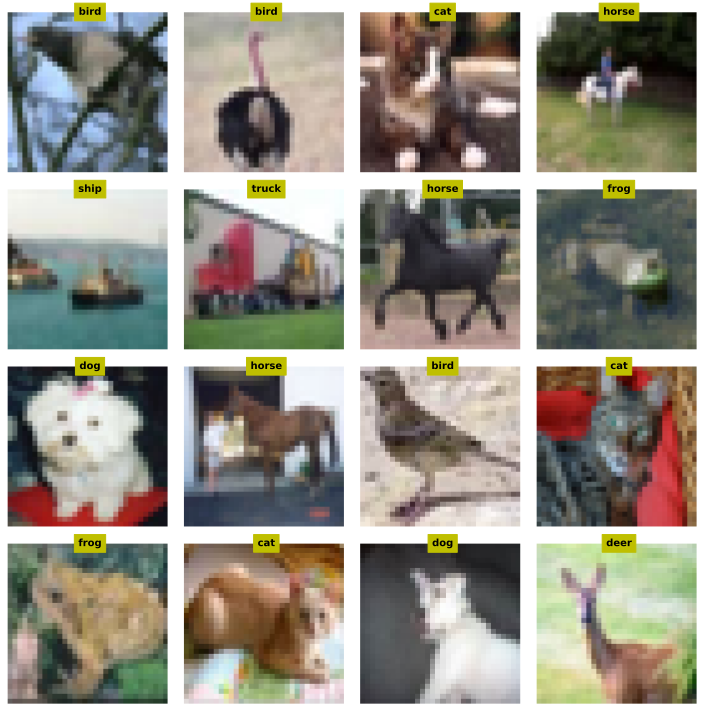

In [46]:
# inspect a few random images

X,y = next(iter(train_loaderSmall))

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic/2 + .5 # undo normalization

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [47]:
# create a class for the model
def makeAENet(printtoggle=False):

    class aenet(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()

            # print toggle
            self.print = printtoggle

            ### -------------- encoding layers -------------- ###
            # first convolution layer
            self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
            # output size: (32+2*1-4)/2 + 1 = 16

            # second convolution layer
            self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
            # output size: (16+2*1-4)/2 + 1 = 8

            # third convolution layer
            self.encconv3  = nn.Conv2d(32,64,4,padding=1,stride=2)
            # output size: (8+2*1-4)/2 + 1 = 4


            ### -------------- decoding layers -------------- ###

            # first convolution layer
            self.decconv1  = nn.ConvTranspose2d(64,32,4,padding=1,stride=2)

            # second convolution layer
            self.decconv2  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)

            # third convolution layer (output)
            self.decconv3  = nn.ConvTranspose2d(16,3,4,padding=1,stride=2)


        def forward(self,x):

            if self.print: print(f'Input: {list(x.shape)}')

            # first encoder layer
            x = F.leaky_relu( self.encconv1(x) )
            if self.print: print(f'First encoder block: {list(x.shape)}')

            # first encoder layer
            x = F.leaky_relu( self.encconv2(x) )
            if self.print: print(f'Second encoder block: {list(x.shape)}')

            # first encoder layer
            x = F.leaky_relu( self.encconv3(x) )
            if self.print: print(f'Third encoder block: {list(x.shape)}')




            # first decoder block
            x = F.leaky_relu( self.decconv1(x) )
            if self.print: print(f'First decoder block: {list(x.shape)}')

            # second decoder block
            x = F.leaky_relu( self.decconv2(x) )
            if self.print: print(f'Second decoder block: {list(x.shape)}')

            # third decoder block (output)
            x = F.leaky_relu( self.decconv3(x) )
            if self.print: print(f'Decoder output: {list(x.shape)}')

            return x

    # create the model instance
    net = aenet(printtoggle)

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

    return net,lossfun,optimizer


In [49]:
# test the model with one batch
aenet,lossfun,optimizer = makeAENet(True)

X,y = next(iter(train_loaderSmall))
yHat = aenet(X)

# now compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First encoder block: [32, 16, 16, 16]
Second encoder block: [32, 32, 8, 8]
Third encoder block: [32, 64, 4, 4]
First decoder block: [32, 32, 8, 8]
Second decoder block: [32, 16, 16, 16]
Decoder output: [32, 3, 32, 32]
 
Loss:
tensor(0.2495, grad_fn=<MseLossBackward0>)


In [50]:
# Function to train model

def trainAEModel(net, lossfn, optim):
    
    nEp = 15
    
    net.to(device)
    
    trainLoss, testLoss = torch.zeros(nEp), torch.zeros(nEp)
    
    batchLoss = []
    
    for i in range(nEp):
        net.train()
        for X,y in train_loaderFull:
            X = X.to(device)
            y = y.to(device)

            yH = net(X)
            loss = lossfn(yH, X)

            optim.zero_grad()
            loss.backward()
            optim.step()

            batchLoss.append(loss.item())
        
        trainLoss[i] = np.mean(batchLoss)
        
        net.eval()
        batchLoss = []
        for X, y in test_loaderFull:
            X = X.to(device)
            y = y.to(device)
            
            with torch.no_grad():
                yH = net(X)
                loss = lossfn(yH, X)
            batchLoss.append(loss.item())
            
        testLoss[i] = np.mean(batchLoss)
        
        
    return net, trainLoss, testLoss        

In [51]:
netAE, lossfn, optim = makeAENet()

netAE, trainLossAE, testLossAE = trainAEModel(netAE, lossfn, optim)

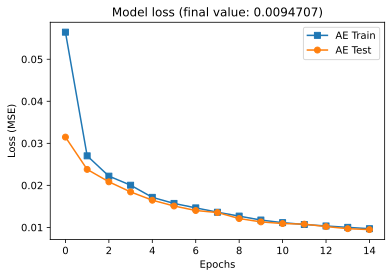

In [52]:
plt.plot(trainLossAE,'s-',label='AE Train')
plt.plot(testLossAE,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)'%testLossAE[-1])
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


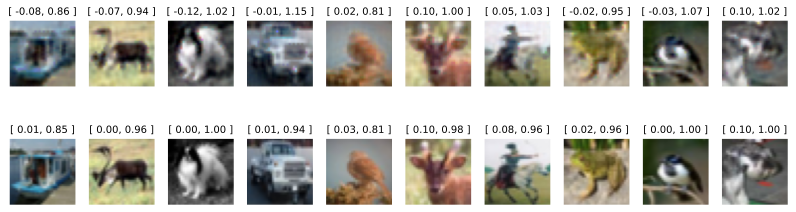

In [53]:
## show some random examples

# get some data
X,y = next(iter(test_loaderSmall))

# forward pass and loss
netAE.cpu()
netAE.eval() # switch to test mode
yHat = netAE(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
    pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
    pic = pic/2 + .5 # undo normalization
    axs[0,i].imshow(pic)
    axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
    axs[0,i].axis('off')

    pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
    pic = pic/2 + .5 # undo normalization
    axs[1,i].imshow(pic)
    axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
    axs[1,i].axis('off')

plt.show()

### Creating a  new model for classification

In [56]:
# create a class for the model
def makeClassifier(printtoggle=False):

    class classNet(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()

            # print toggle
            self.print = printtoggle

            ### -------------- encoding layers -------------- ###
            # first convolution layer
            self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
            # output size: (28+2*1-4)/2 + 1 = 14

            # second convolution layer
            self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
            # output size: (14+2*1-4)/2 + 1 = 7

            # third convolution layer
            self.encconv3  = nn.Conv2d(32,64,4,padding=1,stride=2)
            # output size: (7+2*1-4)/2 + 1 = 4



            ### ------------- linear layers ------------- ###
            self.fc1  = nn.Linear(4*4*64,128)
            self.fc2  = nn.Linear(128,64)
            self.fc3  = nn.Linear(64,10)


        def forward(self,x):

            if self.print: print(f'Input: {list(x.shape)}')

            # first encoder layer
            x = F.leaky_relu(self.encconv1(x))
            if self.print: print(f'First encoder layer: {list(x.shape)}')

            # second encoder layer
            x = F.leaky_relu(self.encconv2(x))
            if self.print: print(f'Second encoder layer: {list(x.shape)}')

            # third encoder layer
            x = F.leaky_relu(self.encconv3(x))
            if self.print: print(f'Third encoder layer: {list(x.shape)}')

            # reshape to linear
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print: print(f'Post-convolution vectorized: {list(x.shape)}')

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            if self.print: print(f'First linear layer: {list(x.shape)}')

            x = F.leaky_relu(self.fc2(x))
            if self.print: print(f'Second linear layer: {list(x.shape)}')

            x = F.leaky_relu(self.fc3(x))
            if self.print: print(f'Output linear layer: {list(x.shape)}')

            return x

    # create the model instance
    net = classNet(printtoggle)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.001)

    return net,lossfun,optimizer

In [58]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeClassifier(True)

X,y = next(iter(train_loaderSmall))
yHat = tmpnet(X)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First encoder layer: [32, 16, 16, 16]
Second encoder layer: [32, 32, 8, 8]
Third encoder layer: [32, 64, 4, 4]
Post-convolution vectorized: [32, 1024]
First linear layer: [32, 128]
Second linear layer: [32, 64]
Output linear layer: [32, 10]
 
Loss:
tensor(2.2939, grad_fn=<NllLossBackward0>)


In [63]:
# a function that trains the model

def trainClassifier(net,lossfun,optimizer,train_loader,test_loader):
    
    # number of epochs
    numepochs = 10

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)
    trainAcc  = torch.zeros(numepochs)
    testAcc   = torch.zeros(numepochs)


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train() # switch to train mode
        batchLoss = []
        batchAcc  = []

        for X,y in train_loader:
            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy from this batch
            batchLoss.append(loss.item())
            batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
            # end of batch loop...

        # and get average losses and accuracies across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi]  = 100*np.mean(batchAcc)



        #### test performance (here done in batches!)
        net.eval() # switch to test mode
        batchLoss = []
        batchAcc  = []

        for X,y in test_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            with torch.no_grad():
                yHat = net(X)
                loss = lossfun(yHat,y)

            # loss and accuracy from this batch
            batchLoss.append(loss.item())
            batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        # end of batch loop...

        # and get average losses and accuracies across the batches
        testLoss[epochi] = np.mean(batchLoss)
        testAcc[epochi]  = 100*np.mean(batchAcc)

    # end epochs

    # function output
    return trainLoss,testLoss,trainAcc,testAcc,net

In [65]:
naivenet, lossfn, optim = makeClassifier()

trainLossNaive,testLossNaive,trainAccNaive,testAccNaive,naivenet = trainClassifier(naivenet, lossfn, optim, train_loaderSmall, test_loaderSmall)

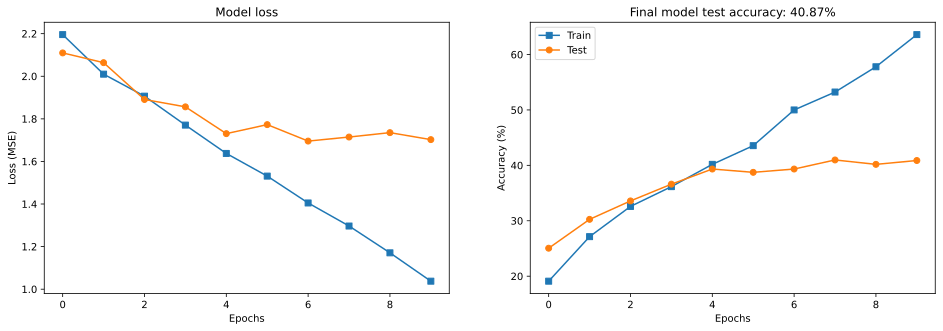

In [66]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossNaive,'s-',label='Train')
ax[0].plot(testLossNaive,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAccNaive,'s-',label='Train')
ax[1].plot(testAccNaive,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAccNaive[-1]:.2f}%')
ax[1].legend()

plt.show()

## Building new model with Encoder part of pre-trained AE

In [79]:
pretrainNet, lossfn, optim = makeClassifier()

# transferring weights of src model encoder part to new model
for tgt, src in zip(pretrainNet.named_parameters(), netAE.named_parameters()):
    if 'encconv' in tgt[0]:
        tgt[1].data = copy.deepcopy(src[1].data)
        
        # freezing all conv weights (optional)
#         tgt[1].requires_grad = False

In [80]:
# double checking that they match

pretrainNet.cpu().encconv1.weight[10] == netAE.cpu().encconv1.weight[10]

tensor([[[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]]])

In [81]:
trainLossPre,testLossPre,trainAccPre,testAccPre,pretrainNet = trainClassifier(pretrainNet, lossfn, optim, train_loaderSmall, test_loaderSmall)

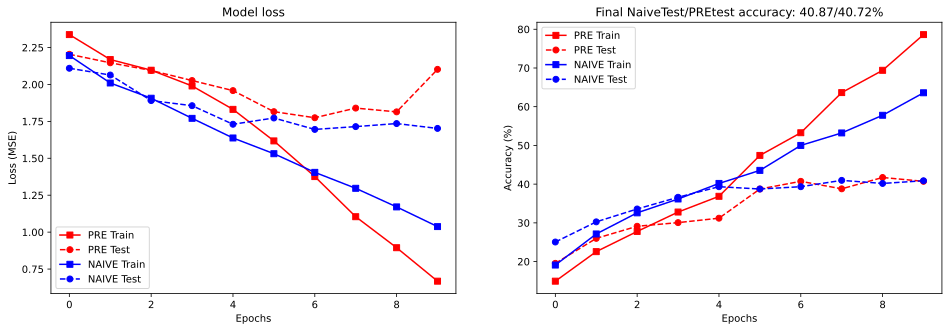

In [82]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossPre,'rs-',label='PRE Train')
ax[0].plot(testLossPre,'ro--',label='PRE Test')
ax[0].plot(trainLossNaive,'bs-',label='NAIVE Train')
ax[0].plot(testLossNaive,'bo--',label='NAIVE Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAccPre,'rs-',label='PRE Train')
ax[1].plot(testAccPre,'ro--',label='PRE Test')
ax[1].plot(trainAccNaive,'bs-',label='NAIVE Train')
ax[1].plot(testAccNaive,'bo--',label='NAIVE Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final NaiveTest/PREtest accuracy: {testAccNaive[-1]:.2f}/{testAccPre[-1]:.2f}%')
ax[1].legend()

plt.show()